# Using temperature_from_filter_ratio to analyze XRT data

This example demonstrates how to use `temperature_from_filter_ratio` to calculate the temperature and emission measure in an image using the filter ratio method.

First we need to import `temperature_from_filter_ratio`.

In [1]:
from xrtpy.response.temperature_from_filter_ratio import temperature_from_filter_ratio

As an example we will use the test data included in XRTpy, though data with the right characteristics in the XRT archive could also be used. It's necessary to use two images that are the same size and different filters. To get good results the images should have been taken close in time as well, ideally adjacent in time. Note that not all filter ratios produce good results. 

This data was generated using the IDL routine xrt_prep.pro from SolarSoft and is unnormalized. Data in the Level 1 archive are normalized, which is also okay to use, though the IDL routine `xrt_teem.pro` did not allow that. For normalized data the image data is multiplied by the exposure time before analysis. 

In [2]:
import pkg_resources
import sunpy.map

from pathlib import Path

/tmp/ipykernel_22932/2480642862.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [3]:
directory = pkg_resources.resource_filename(
    "xrtpy", "response/tests/data/temperature_from_filter_ratio_testing_files"
)

data_files = sorted(Path(directory).glob("L1_XRT20110128_*.*.fits"))

In [4]:
file1 = data_files[1]
file2 = data_files[0]
print("Files used:\n", file1.name, "\n", file2.name)

Files used:
 L1_XRT20110128_013204.9_unnorm.fits 
 L1_XRT20110128_013155.9_unnorm.fits


[Sunpy maps]:https://docs.sunpy.org/en/stable/code_ref/map.html

`temperature_from_filter_ratio` uses [Sunpy maps] as input. 

In [5]:
map1 = sunpy.map.Map(file1)
map2 = sunpy.map.Map(file2)

In [6]:
print(
    map1.fits_header["TELESCOP"],
    map1.fits_header["INSTRUME"],
)
print(
    "\n File 1 used:\n",
    file1.name,
    "\n Observation date:",
    map1.fits_header["DATE_OBS"],
    map1.fits_header["TIMESYS"],
    "\n Filter Wheel 1:",
    map1.fits_header["EC_FW1_"],
    map1.fits_header["EC_FW1"],
    "\n Filter Wheel 2:",
    map1.fits_header["EC_FW2_"],
    map1.fits_header["EC_FW2"],
    "\n Dimension:",
    map1.fits_header["NAXIS1"],
    map1.fits_header["NAXIS1"],
)

print(
    "\nFile 2 used:\n",
    file2.name,
    "\n Observation date:",
    map2.fits_header["DATE_OBS"],
    map2.fits_header["TIMESYS"],
    "\n Filter Wheel 1:",
    map2.fits_header["EC_FW1_"],
    map2.fits_header["EC_FW1"],
    "\n Filter Wheel 2:",
    map2.fits_header["EC_FW2_"],
    map2.fits_header["EC_FW2"],
    "\n Dimension:",
    map2.fits_header["NAXIS1"],
    map2.fits_header["NAXIS1"],
)

HINODE XRT

 File 1 used:
 L1_XRT20110128_013204.9_unnorm.fits 
 Observation date: 2011-01-28T01:32:04.998 UTC (TBR) 
 Filter Wheel 1: Be_thin 3 
 Filter Wheel 2: Open 0 
 Dimension: 384 384

File 2 used:
 L1_XRT20110128_013155.9_unnorm.fits 
 Observation date: 2011-01-28T01:31:55.932 UTC (TBR) 
 Filter Wheel 1: Open 0 
 Filter Wheel 2: Ti_poly 2 
 Dimension: 384 384


The `temperature_from_filter_ratio` function has several options, mirroring the IDL routine xrt_teem.pro in SolarSoft in most respects. A simple call with no extra parameters calculates the temperature and (volume) emission measure for the two images without any binning or masking of the data.

In [7]:
T_EM = temperature_from_filter_ratio(map1, map2)
T_e = T_EM.Tmap

The output of `temperature_from_filter_ratio` is a namedtuple of SunPy maps with attributes `Tmap`, `EMmap`, `Terrmap`, and `EMerrmap`. As with the SolarSoft IDL routine xrt_teem.pro, the output images are logs of the quantities. `Tmap.data` is the electron temperature, `EMmap.data` is the volume emission measure, `Terrmap.data` is a measure of the uncertainties in the temperature determined for each pixel and `EMerrmap.data` is the same for the emission measure. Each map has data and associated metadata. To examine the results one can use `matplotlib` and `sunpy`:

For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs
For frame 'heliographic_carrington' the following metadata is missing: crln_obs,crlt_obs
 [sunpy.map.mapbase]


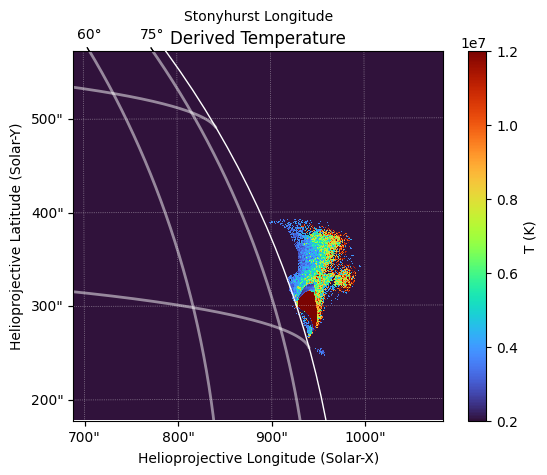

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from sunpy.coordinates.sun import angular_radius, B0
from sunpy.map import Map

# To avoid error messages from sunpy we add metadata to the header:
rsun_ref = 6.95700e08
hdr1 = map1.meta
rsun_obs = angular_radius(hdr1["DATE_OBS"]).value
dsun = rsun_ref / np.sin(rsun_obs * np.pi / 6.48e5)
solarb0 = B0(hdr1["DATE_OBS"]).value
hdr1["DSUN_OBS"] = dsun
hdr1["RSUN_REF"] = rsun_ref
hdr1["RSUN_OBS"] = rsun_obs
hdr1["SOLAR_B0"] = solarb0

fig = plt.figure()
# We could create a plot simply by doing T_e.plot(), but here we choose to make a linear plot of T_e
m = Map((10.0**T_e.data, T_e.meta))
m.plot(title="Derived Temperature", vmin=2.0e6, vmax=1.2e7, cmap="turbo")
m.draw_limb()
m.draw_grid(linewidth=2)
cb = plt.colorbar(label="T (K)")

See the temperature_from_filter_ratio.py script for more information. Among the options are verbose output, binning the data by an integer factor (to increase the signal to noise), specifying a temperature range to examine, providing a mask for excluding regions of the images from the analysis, and setting error thresholds on the temperature and photon noise that differ from the default values.

[Narukage et al. (2014, Solar Phys. 289, 1029)]:https://xrtpy.readthedocs.io/en/stable/bibliography.html
[Guidoni et al. (2015, ApJ 800, 54)]:https://xrtpy.readthedocs.io/en/stable/bibliography.html


These data were analyzed by [Guidoni et al. (2015, ApJ 800, 54)]. See also [Narukage et al. (2014, Solar Phys. 289, 1029)]. 